In [25]:
%load_ext autoreload
%autoreload 2
# 开发用，每次更新重新导入外部函数，实时更新

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import os
import time
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
from a4_helper import *
from eecs598 import reset_seed
from eecs598.grad import rel_error
plt.rcParams["figure.figsize"] = (8, 6.4)  # set default size of plots
plt.rcParams["font.size"] = 16
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")

Good to go!


In [10]:
import multiprocessing

# Set a few constants related to data loading.
NUM_CLASSES = 20
BATCH_SIZE = 16
IMAGE_SHAPE = (224, 224)
NUM_WORKERS = multiprocessing.cpu_count()
print("线程数量：",NUM_WORKERS)

线程数量： 12


In [14]:
from a4_helper import VOC2007DetectionTiny
GOOGLE_DRIVE_PATH   = "./"
train_dataset = VOC2007DetectionTiny(
    GOOGLE_DRIVE_PATH, "train", image_size=IMAGE_SHAPE[0],
    download=False  # True (for the first time)
)  # 读取train数据
val_dataset = VOC2007DetectionTiny(GOOGLE_DRIVE_PATH, "val", image_size=IMAGE_SHAPE[0])  # 读取val数据

print(f"Dataset sizes: train ({len(train_dataset)}), val ({len(val_dataset)})")
# `pin_memory` speeds up CPU-GPU batch transfer, `num_workers=NUM_WORKERS` loads data
# on the main CPU process, suitable for Colab.
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS
)

# Use batch_size = 1 during inference - during inference we do not center crop
# the image to detect all objects, hence they may be of different size. It is
# easier and less redundant to use batch_size=1 rather than zero-padding images.
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, pin_memory=True, num_workers=NUM_WORKERS
)

Dataset sizes: train (2501), val (2510)


In [15]:
train_loader_iter = iter(train_loader)
image_paths, images, gt_boxes = train_loader_iter.next()
print(f"image paths           : {image_paths}")
print(f"image batch has shape : {images.shape}")
print(f"gt_boxes has shape    : {gt_boxes.shape}")

print(f"Five boxes per image  :")
print(gt_boxes[:, :5, :])

image paths           : ['./VOCdevkit/VOC2007/JPEGImages/000012.jpg', './VOCdevkit/VOC2007/JPEGImages/000017.jpg', './VOCdevkit/VOC2007/JPEGImages/000023.jpg', './VOCdevkit/VOC2007/JPEGImages/000026.jpg', './VOCdevkit/VOC2007/JPEGImages/000032.jpg', './VOCdevkit/VOC2007/JPEGImages/000033.jpg', './VOCdevkit/VOC2007/JPEGImages/000034.jpg', './VOCdevkit/VOC2007/JPEGImages/000035.jpg', './VOCdevkit/VOC2007/JPEGImages/000036.jpg', './VOCdevkit/VOC2007/JPEGImages/000042.jpg', './VOCdevkit/VOC2007/JPEGImages/000044.jpg', './VOCdevkit/VOC2007/JPEGImages/000047.jpg', './VOCdevkit/VOC2007/JPEGImages/000048.jpg', './VOCdevkit/VOC2007/JPEGImages/000061.jpg', './VOCdevkit/VOC2007/JPEGImages/000064.jpg', './VOCdevkit/VOC2007/JPEGImages/000066.jpg']
image batch has shape : torch.Size([16, 3, 224, 224])
gt_boxes has shape    : torch.Size([16, 40, 5])
Five boxes per image  :
tensor([[[ 48.9369,  65.2493, 180.1081, 181.6216,   6.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000],
       

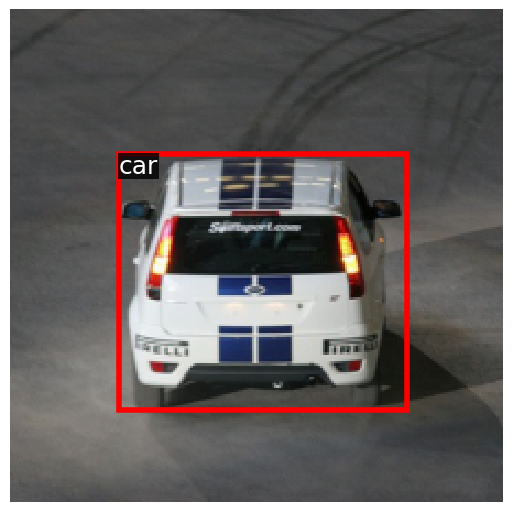

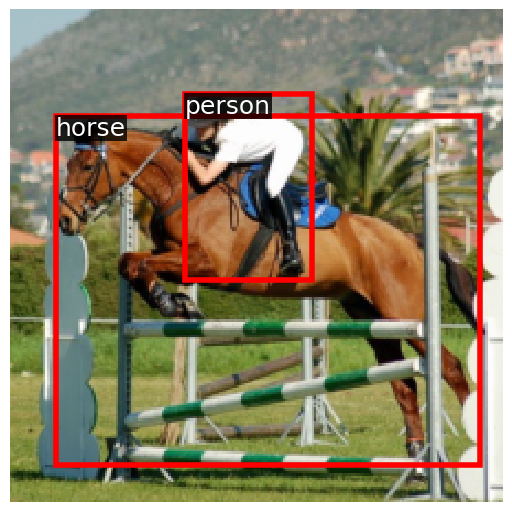

In [21]:
from torchvision import transforms
from eecs598.utils import detection_visualizer
"""
This transform does not support PIL Image. Given mean: (mean[1],...,mean[n]) and std: (std[1],..,std[n]) 
for n channels, this transform will normalize each channel of the input torch.*Tensor i.e., output[channel] = (input[channel] - mean[channel]) / std[channel]
根据公式，当mean=0和std=1时等于不变
"""
# 在读取数据的时候做了一个变换（根据ImageNet），为了可视化图像需要反变换
inverse_norm = transforms.Compose(
    [
        transforms.Normalize(mean=[0., 0., 0.], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
    ]
)

for idx, (_, image, gt_boxes) in enumerate(train_dataset):
    # Stop after visualizing three images.
    if idx >= 2:
        break

    # Un-normalize image to bring in [0, 1] RGB range.
    image = inverse_norm(image)
    # Remove padded boxes from visualization.
    is_valid = gt_boxes[:, 4] >= 0
    detection_visualizer(image, val_dataset.idx_to_class, gt_boxes[is_valid])

For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])
